# Kaggle: Zillow Prize

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import re
%matplotlib inline

## Importing datasets

In [2]:
properties_path = 'https://s3.us-east-2.amazonaws.com/aws-emr-dedicated/data/zillow/properties_2016.csv'
train_path = 'https://s3.us-east-2.amazonaws.com/aws-emr-dedicated/data/zillow/train_2016_v2.csv'

properties = pd.read_csv(filepath_or_buffer=properties_path)
train = pd.read_csv(filepath_or_buffer=train_path)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
properties.set_index('parcelid', inplace=True)
properties['latitude'] = properties['latitude']/1e6
properties['longitude'] = properties['longitude']/1e6

In [4]:
properties_in_train = properties.loc[train['parcelid'].drop_duplicates()]

In [5]:
print(properties.shape)
print(train.shape)
print(properties_in_train.shape)

(2985217, 57)
(90275, 3)
(90150, 57)


## Visualization of missing values

In [6]:
# missing percentage
properties_in_train.count().sort_values() / properties_in_train.shape[0]

buildingclasstypeid             0.000177
finishedsquarefeet13            0.000366
basementsqft                    0.000477
storytypeid                     0.000477
yardbuildingsqft26              0.001054
fireplaceflag                   0.002440
architecturalstyletypeid        0.002884
typeconstructiontypeid          0.003306
finishedsquarefeet6             0.004648
decktypeid                      0.007299
poolsizesum                     0.010715
pooltypeid10                    0.012856
pooltypeid2                     0.013356
taxdelinquencyflag              0.019689
taxdelinquencyyear              0.019689
hashottuborspa                  0.026212
yardbuildingsqft17              0.029340
finishedsquarefeet15            0.039434
finishedfloor1squarefeet        0.075984
finishedsquarefeet50            0.075984
fireplacecnt                    0.106456
threequarterbathnbr             0.133067
pooltypeid7                     0.184936
poolcnt                         0.198292
numberofstories 

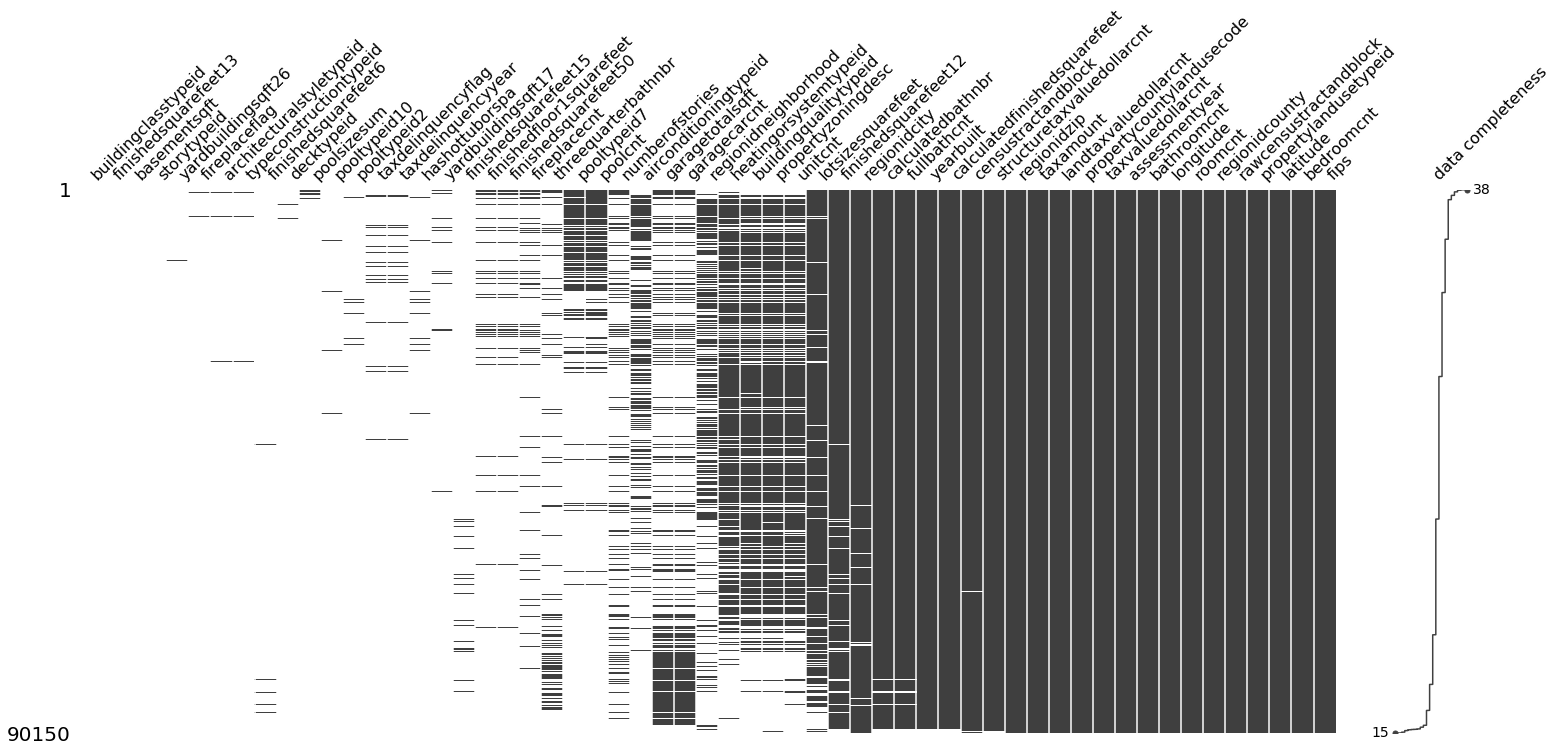

In [7]:
colnames = properties_in_train.count().sort_values().index
msno.matrix(msno.nullity_sort(properties_in_train[colnames], sort='descending'), 
            labels=True)

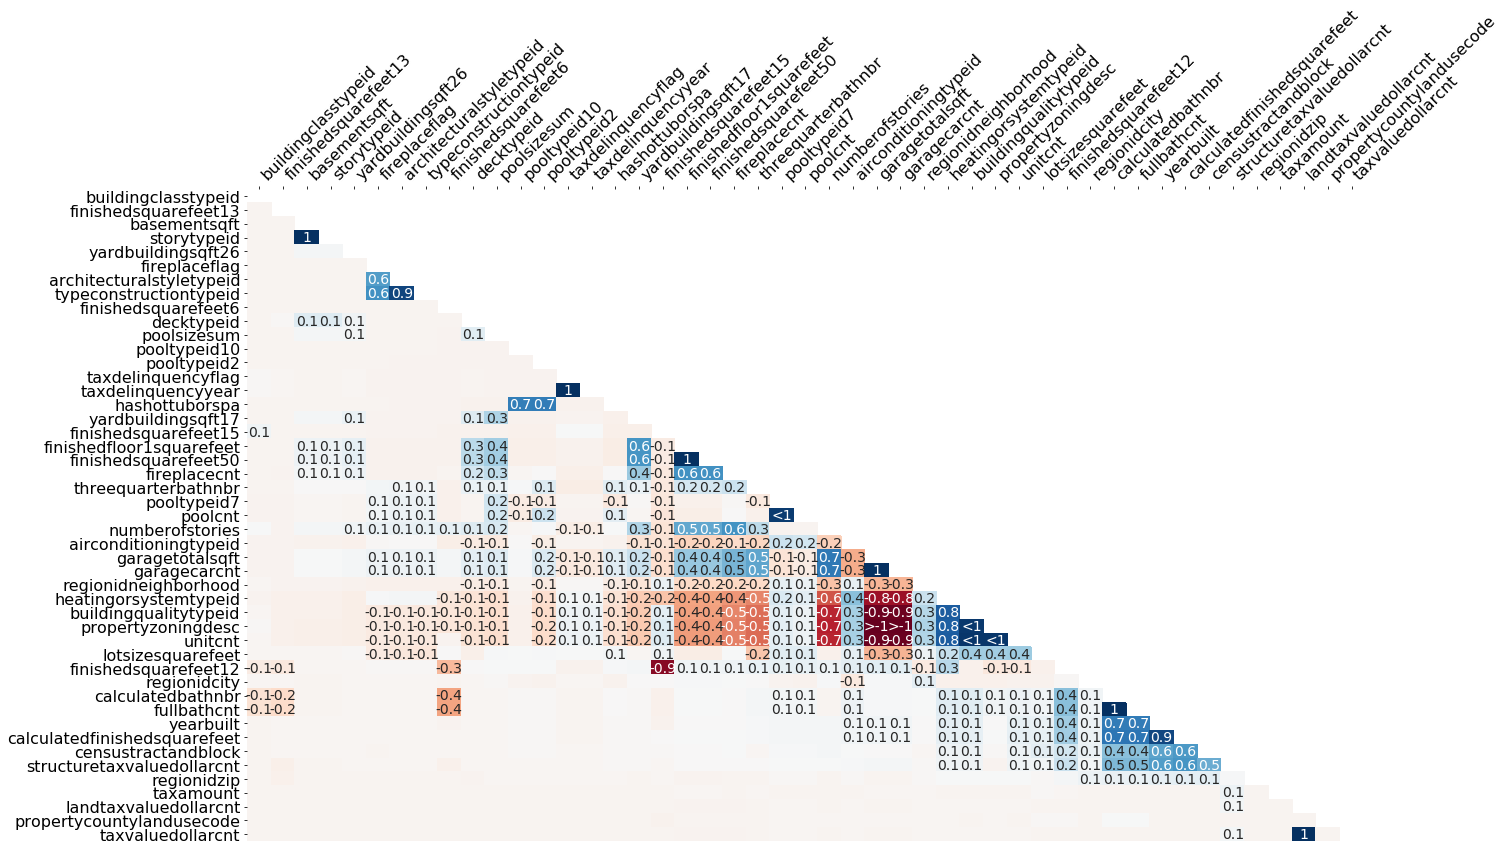

In [8]:
msno.heatmap(properties_in_train[colnames])

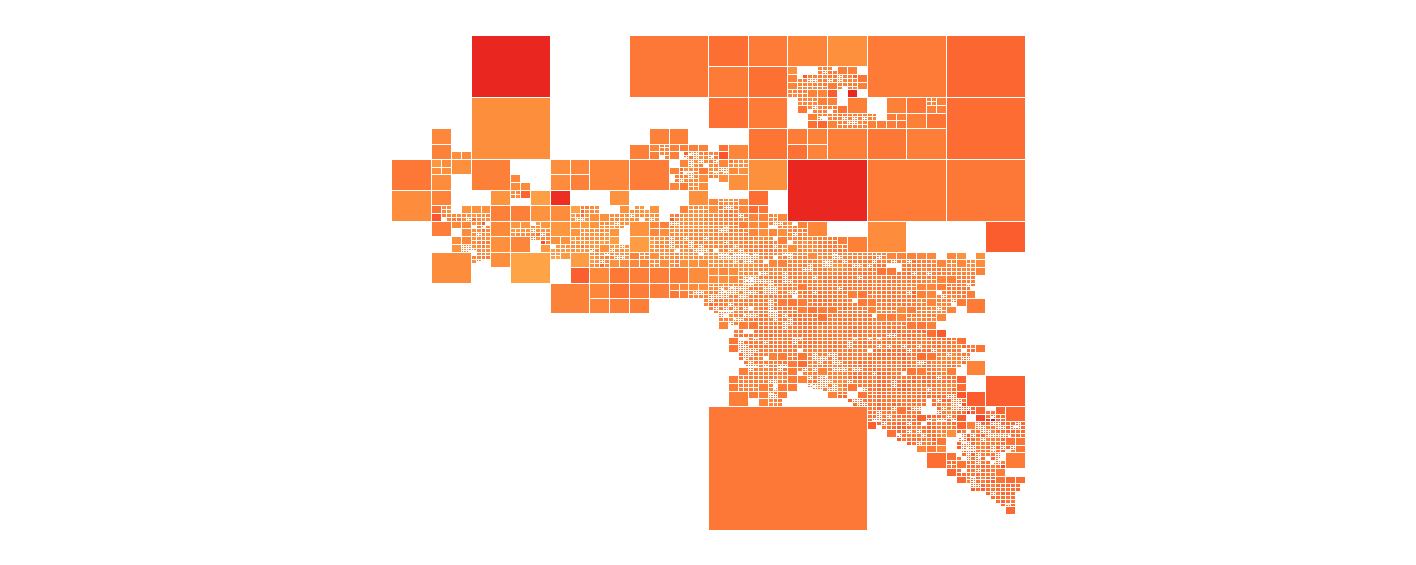

In [9]:
msno.geoplot(properties_in_train, 
             x='longitude', 
             y='latitude')

## Preprocessing data

In [10]:
# taxdelinquencyyear: Year for which the unpaid propert taxes were due 
properties_in_train['taxdelinquencyyear'].value_counts(dropna=False)

NaN      88375
 14.0      626
 15.0      515
 13.0      209
 12.0      153
 10.0       89
 11.0       84
 9.0        63
 8.0        24
 7.0         8
 6.0         3
 99.0        1
Name: taxdelinquencyyear, dtype: int64

In [11]:
def preproc_taxdelinquencyyear(data):
    col = 'taxdelinquencyyear'
    data.loc[data[col] < 20.0, col] = data.loc[data[col] < 20.0, col] + 2000
    data.loc[data[col] < 100.0, col] = data.loc[data[col] < 100.0, col] + 1900
    return data

In [12]:
properties_in_train = preproc_taxdelinquencyyear(properties_in_train)
properties = preproc_taxdelinquencyyear(properties)

In [13]:
# buildingclasstypeid: The building framing type (steel frame, wood frame, concrete/brick) 
print(properties['buildingclasstypeid'].value_counts(dropna=False))
print(properties_in_train['buildingclasstypeid'].value_counts(dropna=False))

NaN     2972588
 4.0       9265
 3.0       3161
 2.0         81
 1.0         65
 5.0         57
Name: buildingclasstypeid, dtype: int64
NaN     90134
 4.0       16
Name: buildingclasstypeid, dtype: int64


In [14]:
def categoryFilter(fit_data, transform_data=[], cols=[], fillna=None):
    for t_data in transform_data:
        for col in cols:
            levels = fit_data.loc[~fit_data[col].isnull(), col].unique()
            t_data.loc[~t_data[col].isin(levels), col] = np.nan
            t_data[col] = t_data[col]
        if fillna is not None:
            t_data = t_data.fillna(fillna)
        yield t_data

In [15]:
# fix categories in column buildingclasstypeid
# demo
a, b = categoryFilter(
    fit_data=properties_in_train, 
    transform_data=[properties_in_train, properties], 
    cols=['taxdelinquencyflag'], 
)

In [17]:
drop_cols = [
    'fips', # fips is identical to regionidcounty
    'propertycountylandusecode',
    'censustractandblock',
    'propertyzoningdesc',
    'rawcensustractandblock',
    'regionidcity',
    'regionidneighborhood',
    'regionidzip',
    'assessmentyear', # same year
    'hashottuborspa',
    'taxdelinquencyflag',
]

# categorical columns
categorical_cols = [x for x in properties_in_train.columns if re.search('id$', x)]

In [18]:
for col in properties_in_train.columns:
    print('preprocessing {}...'.format(col))
    # drop columns
    if col in drop_cols:
        properties_in_train = properties_in_train.drop(col, axis=1)
        properties = properties.drop(col, axis=1)
    # fix categorical levels
    elif col in categorical_cols:
        properties_in_train, properties = categoryFilter(
            fit_data=properties_in_train, 
            transform_data=[properties_in_train, properties], 
            cols=[col], 
            fillna=0
        )
print('done!')

preprocessing airconditioningtypeid...
preprocessing architecturalstyletypeid...
preprocessing basementsqft...
preprocessing bathroomcnt...
preprocessing bedroomcnt...
preprocessing buildingclasstypeid...
preprocessing buildingqualitytypeid...
preprocessing calculatedbathnbr...
preprocessing decktypeid...
preprocessing finishedfloor1squarefeet...
preprocessing calculatedfinishedsquarefeet...
preprocessing finishedsquarefeet12...
preprocessing finishedsquarefeet13...
preprocessing finishedsquarefeet15...
preprocessing finishedsquarefeet50...
preprocessing finishedsquarefeet6...
preprocessing fips...
preprocessing fireplacecnt...
preprocessing fullbathcnt...
preprocessing garagecarcnt...
preprocessing garagetotalsqft...
preprocessing hashottuborspa...
preprocessing heatingorsystemtypeid...
preprocessing latitude...
preprocessing longitude...
preprocessing lotsizesquarefeet...
preprocessing poolcnt...
preprocessing poolsizesum...
preprocessing pooltypeid10...
preprocessing pooltypeid2...


In [19]:
# impute na with -1
properties_in_train.fillna(-1, inplace=True)
properties.fillna(-1, inplace=True)

In [20]:
properties_in_train.dtypes

airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64


In [21]:
properties_in_train['fireplaceflag'].value_counts()

0       89930
True      220
Name: fireplaceflag, dtype: int64

In [ ]:
from sklearn import preprocessing

# create a LabelEncoder instance
encoder = preprocessing.LabelEncoder()
# fit LabelEncoder
encoder.fit(properties_in_train['fireplaceflag'].astype(str))
# transform training set & test set based on training set
properties_in_train['fireplaceflag'] = encoder.transform(properties_in_train['fireplaceflag'].astype(str))
properties['fireplaceflag'] = encoder.transform(properties['fireplaceflag'].astype(str))

In [ ]:
def preproc_buildingclasstypeid(data):
    col = 'buildingclasstypeid'
    data.loc[data[col] != 4, col] = np.nan
    data.loc[data[col] == 4, col] = 1
    data.loc[:, col].fillna(0, inplace=True)
    return data

In [ ]:
# finishedsquarefeet13: Perimeter living area
properties['finishedsquarefeet13'].hist(bins=50)
properties_in_train['finishedsquarefeet13'].hist()

In [ ]:
def preproc_finishedsquarefeet13(data):
    col = 'finishedsquarefeet13'
    data.loc[:, col].fillna(-1, inplace=True)
    return data

In [ ]:
# basementsqft: Finished living area below or partially below ground level
properties['basementsqft'].hist(bins=50)
properties_in_train['basementsqft'].hist()

In [ ]:
# storytypeid: Type of floors in a multi-story house
print(properties['storytypeid'].value_counts(dropna=False))
print(properties_in_train['storytypeid'].value_counts(dropna=False))

In [ ]:
def preproc_storytypeid(data):
    data = data.drop('storytypeid', axis=1)
    return data

def preproc_basementsqft(data):
    data.loc[:, 'basementsqft'].fillna(-1, inplace=True)
    return data 

In [ ]:
# yardbuildingsqft26: Storage shed/building in yard
properties['yardbuildingsqft26'].hist(bins=50)
properties_in_train['yardbuildingsqft26'].hist()

In [ ]:
def preproc_yardbuildingsqft26(data):
    data.loc[:, 'yardbuildingsqft26'].fillna(-1, inplace=True)
    return data

In [ ]:
# regionidcounty & fips
pd.pivot_table(properties, 
               values='latitude',
               index=['fips'],
               columns=['regionidcounty'], 
               aggfunc=len)

In [ ]:
pd.pivot_table(properties_in_train, 
               values='latitude',
               index=['fips'],
               columns=['regionidcounty'], 
               aggfunc=len)

In [ ]:
def preproc_regionidcounty(data):
    col = 'regionidcounty'
    data.loc[data[col] == 3101.0, col] = 1
    data.loc[data[col] == 1286.0, col] = 2
    data.loc[data[col] == 2061.0, col] = 3
    data.loc[:, col].fillna(0, inplace=True)
    return data

def preproc_fips(data):
    data = data.drop('fips', axis=1)
    return data

In [ ]:
# fireplaceflag:Is a fireplace present in this home 
properties['fireplaceflag'].value_counts(dropna=False)

In [ ]:
def preproc_fireplaceflag(data):
    col = 'fireplaceflag'
    data.loc[data[col] == True, col] == 1
    data.loc[:, col].fillna(0, inplace=True)
    return data

In [ ]:
# architecturalstyletypeid: Architectural style of the home
print(properties['architecturalstyletypeid'].value_counts(dropna=False))
print(properties_in_train['architecturalstyletypeid'].value_counts(dropna=False))

In [ ]:
def preproc_architecturalstyletypeid(data):
    col = 'architecturalstyletypeid'
    levels = [2.0,3.0,7.0,8.0,10.0,21.0]
    data.loc[~data[col].isin(levels), col] = 0
    data.loc[:, col].fillna(0, inplace=True)
    return data

In [ ]:
# typeconstructiontypeid: What type of construction material was used to construct the home
print(properties['typeconstructiontypeid'].value_counts(dropna=False))
print(properties_in_train['typeconstructiontypeid'].value_counts(dropna=False))

In [ ]:
def preproc_typeconstructiontypeid(data):
    col = 'typeconstructiontypeid'
    levels = [4.0, 6.0, 13.0]
    data.loc[~data[col].isin(levels), col] = 0
    data.loc[:, col].fillna(0, inplace=True)
    return data

In [ ]:
# finishedsquarefeet6: Base unfinished and finished area
properties.loc[properties['finishedsquarefeet6'] < properties['finishedsquarefeet6'].quantile(0.995), 
               'finishedsquarefeet6'].hist(bins=50)
properties_in_train['finishedsquarefeet6'].hist(bins=50)

In [ ]:
def preproc_finishedsquarefeet6(data):
    data.loc[:, 'finishedsquarefeet6'].fillna(-1, inplace=True)
    return data

In [ ]:
# decktypeid: Type of deck (if any) present on parcel
print(properties['decktypeid'].value_counts(dropna=False))
print(properties_in_train['decktypeid'].value_counts(dropna=False))

In [ ]:
def preproc_decktypeid(data):
    col = 'decktypeid'
    data.loc[data[col] == 66.0, col] = 1
    data.loc[:, col].fillna(0, inplace=True)
    return data

In [ ]:
# poolsizesum: Total square footage of all pools on property
properties_in_train['poolsizesum'].hist(bins=50)

In [ ]:
# pooltypeid10
print(properties['pooltypeid10'].value_counts(dropna=False))
print(properties['pooltypeid2'].value_counts(dropna=False))
print(properties['pooltypeid7'].value_counts(dropna=False))
print(properties['poolcnt'].value_counts(dropna=False))

In [ ]:
msno.matrix(msno.nullity_sort(properties_in_train[['poolsizesum',
                                                   'poolcnt',
                                                   'pooltypeid2',
                                                   'pooltypeid7',
                                                   'pooltypeid10']], 
                              sort='descending'), 
            labels=True)

In [ ]:
def preproc_pooltype(data):
    data.loc[:, 'poolcnt'].fillna(0, inplace=True)
    data.loc[:, 'pooltypeid2'].fillna(0, inplace=True)
    data.loc[:, 'pooltypeid7'].fillna(0, inplace=True)
    data.loc[:, 'pooltypeid10'].fillna(0, inplace=True)
    data['pooltype'] = data['pooltypeid10'] + data['pooltypeid7']*2 + data['pooltypeid2']*3
    data = data.drop('pooltypeid2', axis=1).drop('pooltypeid7', axis=1).drop('pooltypeid10', axis=1)
    return data

In [ ]:
# taxdelinquencyflag
print(properties['taxdelinquencyflag'].value_counts(dropna=False))

In [ ]:
properties['taxdelinquencyyear'].hist(bins=50)

In [ ]:
def preproc_taxdelinquencyflag(data):
    col = 'taxdelinquencyflag'
    data.loc[:, col].fillna(0, inplace=True)
    data.loc[data[col] == 'Y', col] = 1
    return data

def preproc_taxdelinquencyyear(data):
    col = 'taxdelinquencyyear'
    data.loc[data[col] < 20.0, col] = data.loc[data[col] < 2.0, col] + 2000
    data.loc[data[col] < 100.0, col] = data.loc[data[col] < 100.0, col] + 1900
    data.loc[:, col].fillna(0, inplace=True)
    return data

In [ ]:
properties_in_train = preprocessing(
    properties_in_train, 
    preproc_buildingclasstypeid,
    preproc_finishedsquarefeet13,
    preproc_basementsqft,
    preproc_storytypeid,
    preproc_yardbuildingsqft26,
    preproc_regionidcounty,
    preproc_fips,
    preproc_fireplaceflag,
    preproc_architecturalstyletypeid,
    preproc_typeconstructiontypeid,
    preproc_finishedsquarefeet6,
    preproc_decktypeid,
    preproc_pooltype,
    preproc_taxdelinquencyflag,
    preproc_taxdelinquencyyear,
)

In [ ]:
properties = preprocessing(
    properties, 
    preproc_buildingclasstypeid,
    preproc_finishedsquarefeet13,
    preproc_basementsqft,
    preproc_storytypeid,
    preproc_yardbuildingsqft26,
    preproc_regionidcounty,
    preproc_fips,
    preproc_fireplaceflag,
    preproc_architecturalstyletypeid,
    preproc_typeconstructiontypeid,
    preproc_finishedsquarefeet6,
    preproc_decktypeid,
    preproc_pooltype,
    preproc_taxdelinquencyflag,
    preproc_taxdelinquencyyear,
)

## Data Preparation

In [ ]:
train_set = pd.merge(
    properties_in_train.dropna(axis=1), 
    train, 
    left_index = True, 
    right_on='parcelid'
)
train_set['month'] = pd.to_datetime(train_set['transactiondate']).dt.month
train_set = train_set.drop('parcelid', axis=1).drop('transactiondate', axis=1).drop('assessmentyear', axis=1)

In [ ]:
X = train_set.drop('logerror', axis=1)
y = train_set['logerror']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

## Cross Validation

#### RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[5,10,20],'n_jobs':[-1],'oob_score':[False]}

rf_reg = RandomForestRegressor(verbose=1)
rf_cv = GridSearchCV(rf_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=3)  
rf_cv.fit(X_train, y_train)

In [ ]:
print(rf_cv.best_params_)

In [ ]:
feature_imp = pd.DataFrame.from_dict({'feature':X_train.columns,
                                      'importance':rf_cv.best_estimator_.feature_importances_})
feature_imp.set_index('feature',
                      inplace=True, 
                      drop=True)
feature_imp = feature_imp.sort_values('importance', ascending=False)
feature_imp.plot.bar()

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, rf_cv.best_estimator_.predict(X_test))

#### GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

parameters = {'n_estimators':[5,10,20],
              'learning_rate':[0.01, 0.1],
              'max_depth':[1,3,5]
             }

gb_reg = GradientBoostingRegressor(verbose=1)
gb_cv = GridSearchCV(gb_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=3)  
gb_cv.fit(X_train, y_train)

In [ ]:
print(gb_cv.best_params_)

In [ ]:
mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test))

## Final model fit

In [ ]:
gb_final = GradientBoostingRegressor(**gb_cv.best_params_)

In [ ]:
gb_final.fit(X, y)

In [ ]:
test_set = properties
test_set['month'] = 11
test_set = test_set[X.columns].dropna(axis=0)

test_pred = gb_final.predict(test_set)

In [ ]:
prediction = pd.DataFrame.from_dict({'index':test_set.index,
                                     'predict':test_pred})
prediction.set_index('index')